In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# read csv file
url = "https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/vaccination/aefi.csv"
data = pd.read_csv(url)

# convert the 'date' column to datetime, allowing mixed formats
data['date'] = pd.to_datetime(data['date'], dayfirst=True, errors='coerce')

# define the date range
start_date = '2021-04-15'
end_date = '2021-10-15'

# filter the data within the specified date range
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

C:\Users\cheng\AppData\Local\Temp\ipykernel_15224\2432432701.py:6: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data['date'], dayfirst=True, errors='coerce')


In [3]:
print(data.head())
print(data.describe())
print(data.info())
print(data.columns)
print(data.shape)
print(data.isnull().sum())
print(data.dtypes)

        date      vaxtype  daily_total  daily_serious_npra  daily_nonserious  \
0 2021-01-13  astrazeneca            5                   0                 5   
1 2021-02-25       pfizer            1                   0                 1   
2 2021-02-26       pfizer            2                   0                 2   
3 2021-02-27       pfizer            4                   0                 4   
4 2021-02-28       pfizer           12                   1                11   

   daily_nonserious_npra  daily_nonserious_mysj_dose1  \
0                      5                            0   
1                      1                            0   
2                      2                            0   
3                      4                            0   
4                     11                            0   

   daily_nonserious_mysj_dose2  d1_site_pain  d1_site_swelling  ...  \
0                            0             0                 0  ...   
1                            0    

In [4]:
# Drop columns and left the selected columns
data.drop(['date','daily_nonserious','daily_nonserious_mysj_dose1',
        'daily_nonserious_mysj_dose2','d1_site_swelling',
        'd1_site_redness', 'd1_tiredness', 'd1_muscle_pain',
        'd1_joint_pain', 'd1_weakness', 'd1_vomiting', 'd1_chills',
        'd1_rash',  'd2_site_swelling', 'd2_site_redness',
        'd2_tiredness','d2_muscle_pain', 'd2_joint_pain',
        'd2_weakness', 'd2_vomiting', 'd2_chills', 'd2_rash'], axis=1, inplace=True)

print(data.columns)


Index(['vaxtype', 'daily_total', 'daily_serious_npra', 'daily_nonserious_npra',
       'd1_site_pain', 'd1_headache', 'd1_fever', 'd2_site_pain',
       'd2_headache', 'd2_fever'],
      dtype='object')


In [5]:
# check number of vaxtype in vaxtype column
print(data['vaxtype'].nunique())

# print out the vaxtype name
vaxtype_name = data['vaxtype'].unique()
print(vaxtype_name)

4
['astrazeneca' 'pfizer' 'sinovac' 'sinopharm']


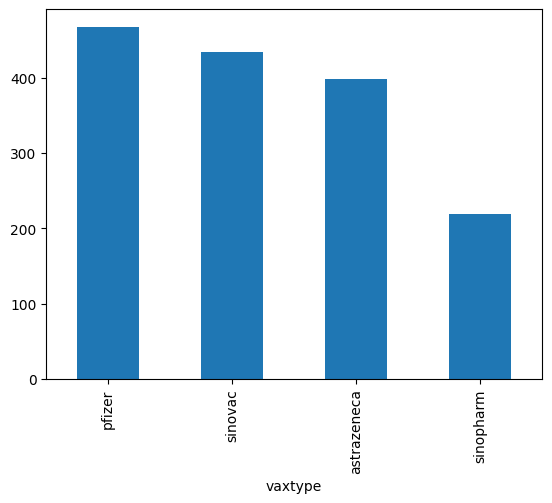

In [6]:
# check frequency of vaxtype in graph
data['vaxtype'].value_counts().plot(kind='bar')
plt.show()

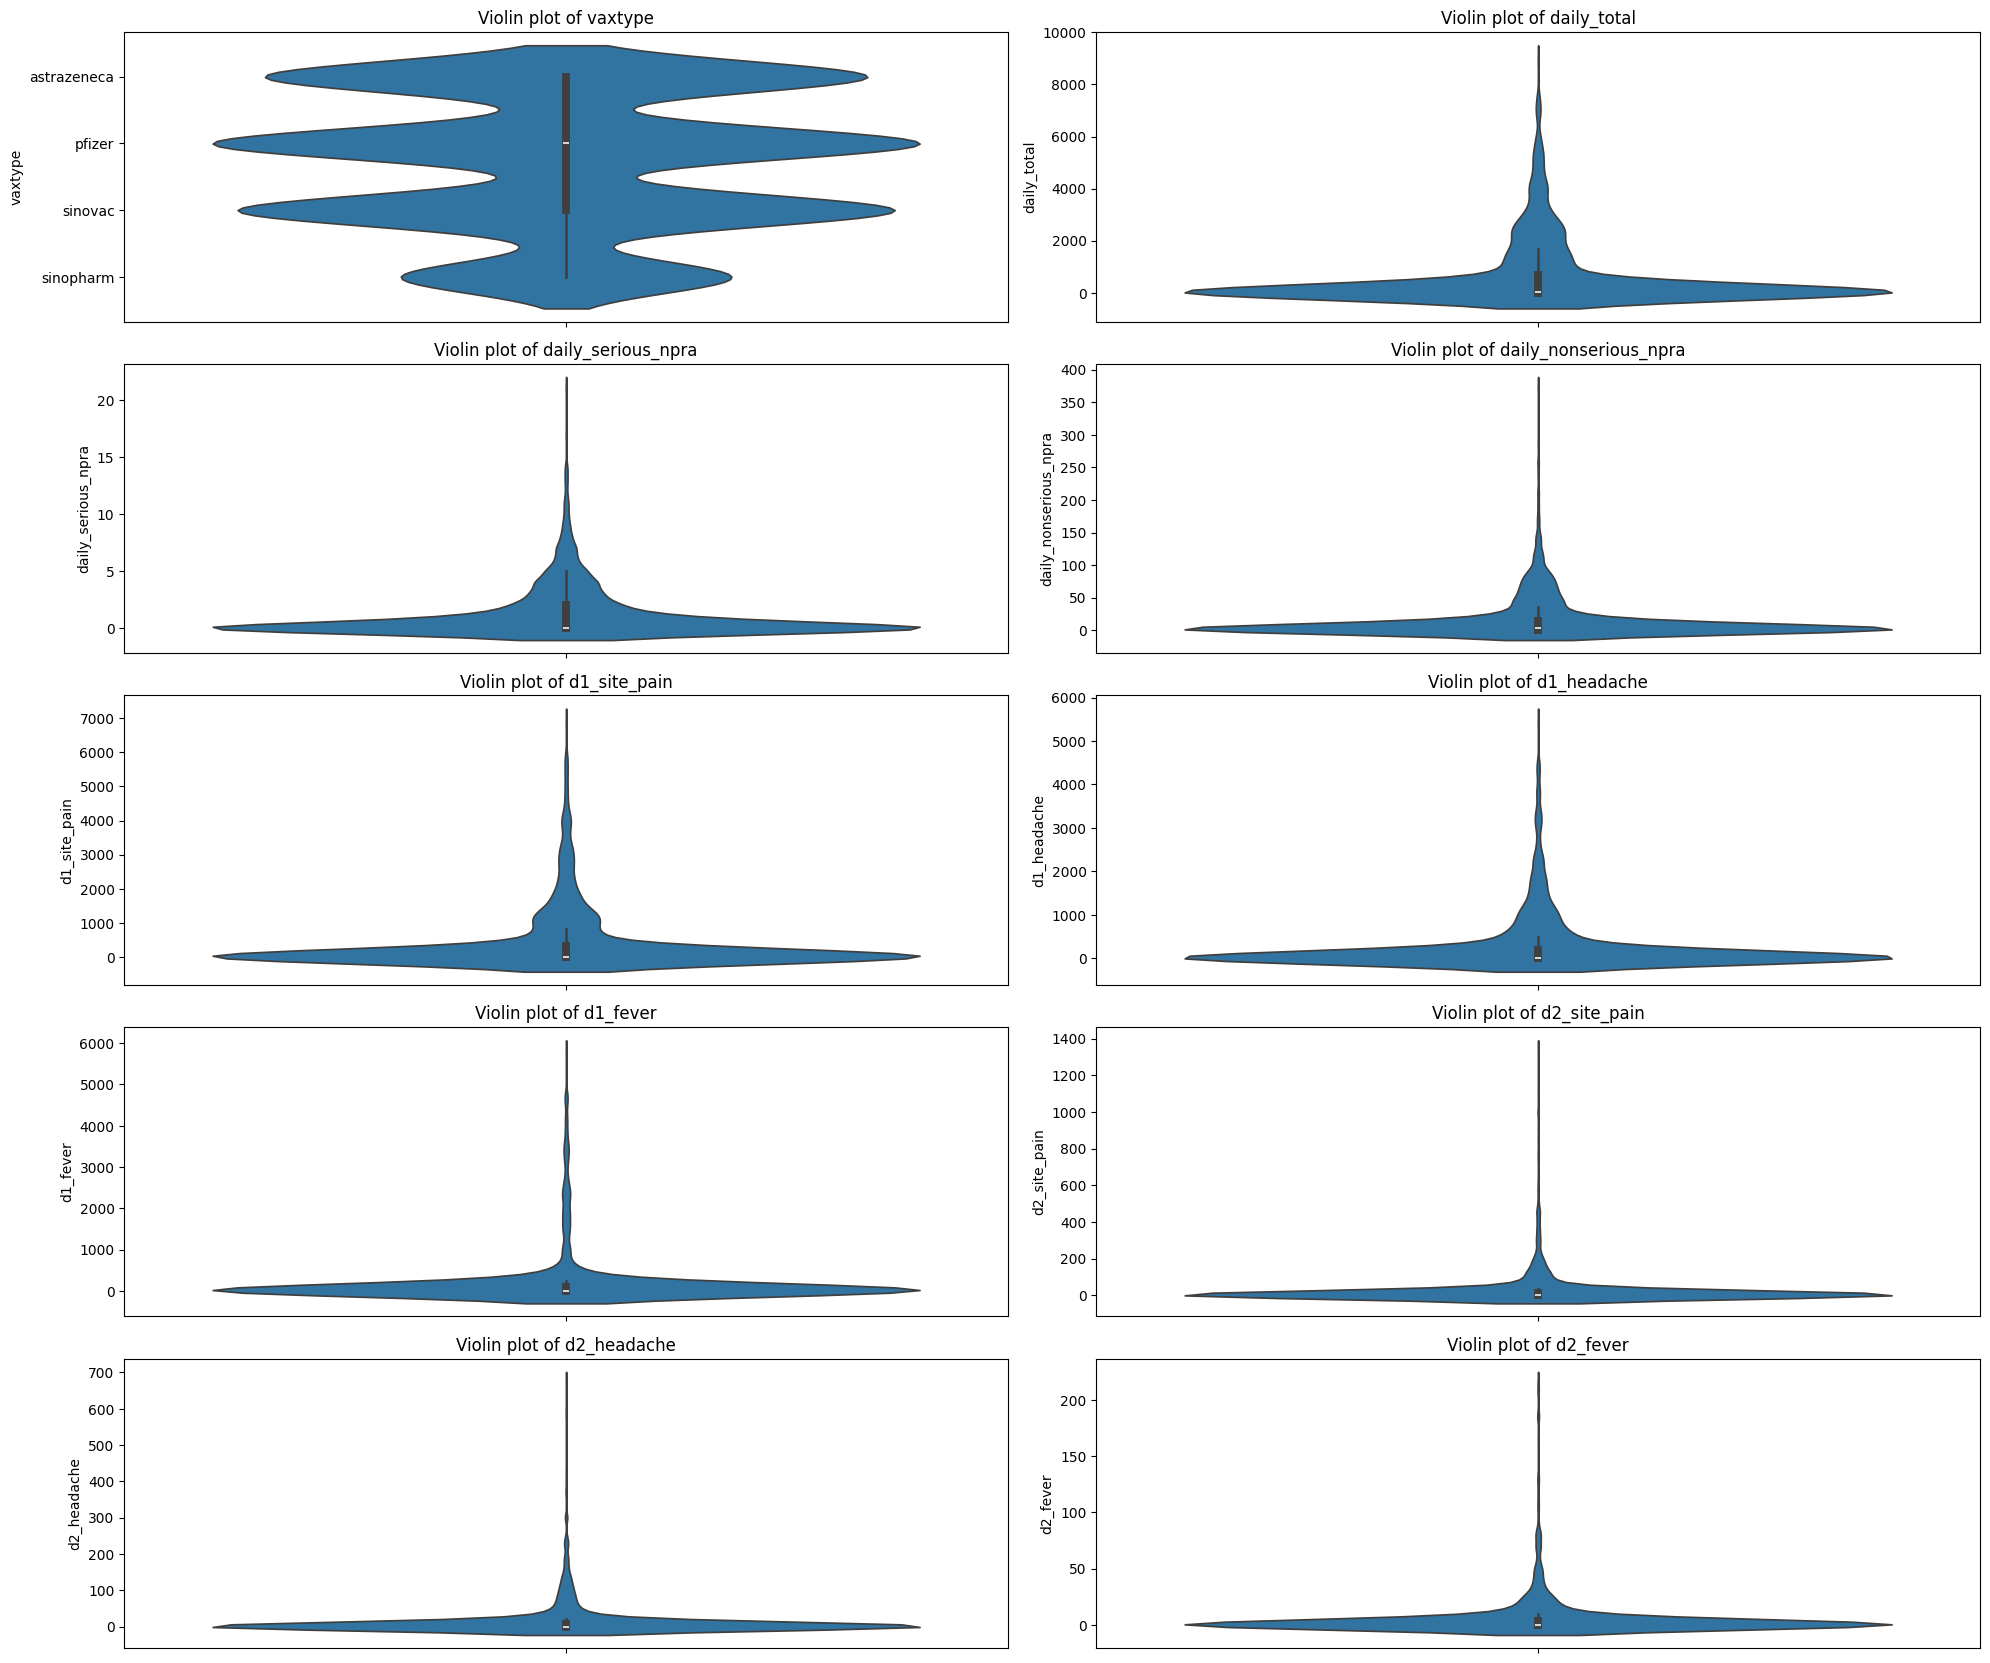

In [7]:
# violin plot to check outliers
plt.figure(figsize=(20,20))

# loop through the columns of your dataset to plot violin plots
for i, column in enumerate(data.columns, 1):
    plt.subplot(len(data.columns)//2 + 1, 2, i)  # to adjust subplot grid
    sns.violinplot(data=data[column])
    plt.title(f'Violin plot of {column}')

plt.tight_layout()
plt.show()

In [8]:
# convert the vaxtype colummn from category to numerical (alternative method/based on alphebetical order to assign numerical value)
# data['vaxtype'] = data['vaxtype'].astype('category')
# data['vaxtype'] = data['vaxtype'].cat.codes

# convert the vaxtype colummn from category to numerical
vaxtype_mapping = {'pfizer': 0, 'sinovac': 1, 'astrazeneca': 2, 'sinopharm': 3}
data['vaxtype'] = data['vaxtype'].map(vaxtype_mapping)

# check the fequency of each vaxtype
vaxtype_freq = data['vaxtype'].value_counts()
print(vaxtype_freq)

vaxtype
0    468
1    435
2    399
3    219
Name: count, dtype: int64


In [9]:
# remove Sinopharm vaxtype related rows from the dataset
data = data[data['vaxtype'] != 3]
print(data['vaxtype'].value_counts())

vaxtype
0    468
1    435
2    399
Name: count, dtype: int64


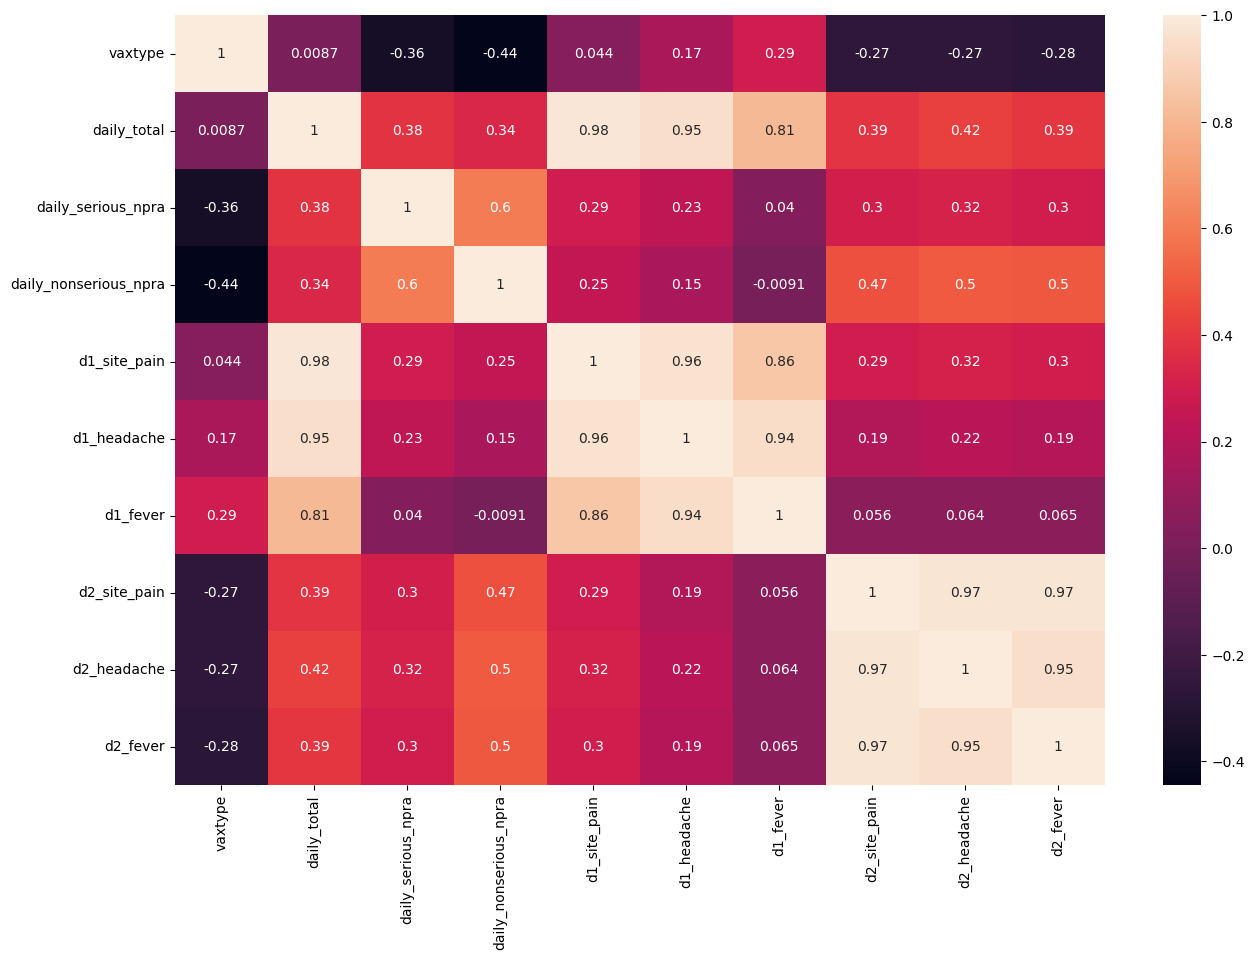

In [10]:
import seaborn as sns

# check the correlation between all the columns in the dataframe
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [11]:
# do Variance inflation factor to check for multicollinearity
def calculate_vif(data):
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return(vif)

print(calculate_vif(data))

               variables         VIF
0                vaxtype    1.297601
1            daily_total  344.337468
2     daily_serious_npra    2.796663
3  daily_nonserious_npra    2.906362
4           d1_site_pain   87.308251
5            d1_headache  371.806934
6               d1_fever   80.130662
7           d2_site_pain   40.426905
8            d2_headache   23.835989
9               d2_fever   22.339223


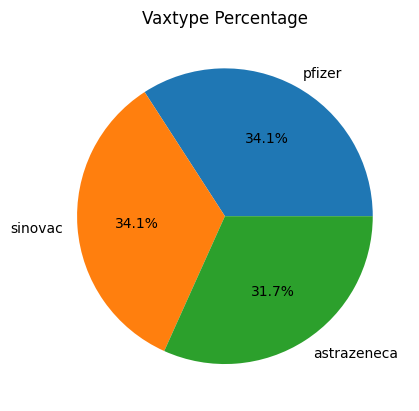

In [12]:
# use SMOTE to over-smapling the dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority',random_state=42)
X = data.drop('vaxtype', axis=1)
y = data['vaxtype']
X_res, y_res = sm.fit_resample(X, y)

# check in percentage of vaxtype in piechart
vaxtype_percentage = y_res.value_counts(normalize=True)
# label the index
vaxtype_percentage.index = ['pfizer', 'sinovac', 'astrazeneca']
plt.title('Vaxtype Percentage')
plt.pie(vaxtype_percentage, labels=vaxtype_percentage.index, autopct='%1.1f%%')
plt.show()


## Data Preprocessing

In [13]:
# check for duplicates in the dataset
duplicates = data.duplicated(keep=False)
if duplicates.sum() > 0:
    # print the number of duplicates in each column
    duplicate_rows = data[duplicates]
    print("Number of duplicates in each column:")
    print(duplicate_rows.apply(lambda x: x.duplicated().sum(), axis=0))
    
    # drop duplicates
    data.drop_duplicates(inplace=True)
    print("Duplicates removed.")
else:
    print("No duplicates found.")


Number of duplicates in each column:
vaxtype                  283
daily_total              279
daily_serious_npra       283
daily_nonserious_npra    279
d1_site_pain             284
d1_headache              284
d1_fever                 284
d2_site_pain             285
d2_headache              285
d2_fever                 285
dtype: int64
Duplicates removed.


In [14]:
# check if there are any null values in the DataFrame
if data.isnull().sum().sum() > 0:
    # fill only numeric columns with their mean values 
    data.fillna(data.select_dtypes(include=['number']).mean(), inplace=True)
    print("Done filling missing values in numeric columns.")
else:
    print("No null values found.")

No null values found.


In [15]:
# split the dataset into 80% training, 10% testing and 10% validation set
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# check the shape of the dataset
print("Size of the dataset:")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# check the shape of the target
print("Size of the target:")
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

Size of the dataset:
(1096, 9)
(137, 9)
(138, 9)
Size of the target:
(1096,)
(137,)
(138,)


In [16]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grids for each model
param_grid_knn = {
    'n_neighbors': [3, 5, 11, 19, 51],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan or Euclidean distance
}

param_grid_mlp = {
    'hidden_layer_sizes': [(26,26), (50,50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'learning_rate': ['constant'],
    'alpha': [0.0001, 0.001],
    'max_iter': [200]
}

param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

param_grid_gnb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Define the models list with hyperparameter tuning using GridSearchCV
models = []
models.append(('KNN', GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)))
models.append(('MLP', GridSearchCV(MLPClassifier(random_state=42), param_grid_mlp, cv=5)))
models.append(('DecisionTree', GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_tree, cv=5)))
models.append(('GaussianNB', GridSearchCV(GaussianNB(), param_grid_gnb, cv=5)))



In [17]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# train the model using training and validation data
for name, model in models:
    try:
        startTraining = time.time()   # start Training time
        model.fit(X_train, y_train)
        endTraining = time.time()     # end Training time
        print(name, 'trained,', 'Time taken:', \
            time.strftime("%H:%M:%S  ", time.gmtime(endTraining - startTraining)))
        #reset the time for next model
        startTraining = endTraining = 0
    except Exception as e:
        print("Input error:", e)

KNN trained, Time taken: 00:00:00  
MLP trained, Time taken: 00:00:10  
DecisionTree trained, Time taken: 00:00:02  
GaussianNB trained, Time taken: 00:00:00  


In [18]:
# y_pred to store the predicted values from each model
# y_pred_proba to store probabilities from each model
y_pred = []                 #for confusion matrix
y_pred_proba = []           #for ROC curve

for name, model in models:
    try:
        startPredicting = time.time()   # start predicting time
        y_pred.append(model.predict(X_val))
        y_pred_proba.append(model.predict_proba(X_val))
        endPredicting = time.time()     # end predicting time
        print(name, 'predicted,', 'Time taken:', \
              time.strftime("%H:%M:%S  ", time.gmtime(endPredicting - startPredicting)))
        #reset the time for next model
        startPredicting = endPredicting = 0
    except Exception as e:
        print("Input error:", e)

KNN predicted, Time taken: 00:00:00  
MLP predicted, Time taken: 00:00:00  
DecisionTree predicted, Time taken: 00:00:00  
GaussianNB predicted, Time taken: 00:00:00  


KNN
Accuracy:  0.6594202898550725
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        48
           1       0.53      0.45      0.49        44
           2       0.64      0.74      0.69        46

    accuracy                           0.66       138
   macro avg       0.65      0.65      0.65       138
weighted avg       0.66      0.66      0.66       138

[[37  8  3]
 [ 8 20 16]
 [ 2 10 34]]


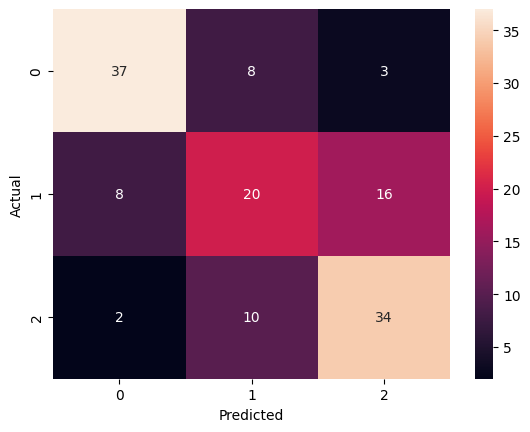

MLP
Accuracy:  0.7101449275362319
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        48
           1       0.63      0.50      0.56        44
           2       0.65      0.80      0.72        46

    accuracy                           0.71       138
   macro avg       0.71      0.71      0.70       138
weighted avg       0.71      0.71      0.71       138

[[39  7  2]
 [ 4 22 18]
 [ 3  6 37]]


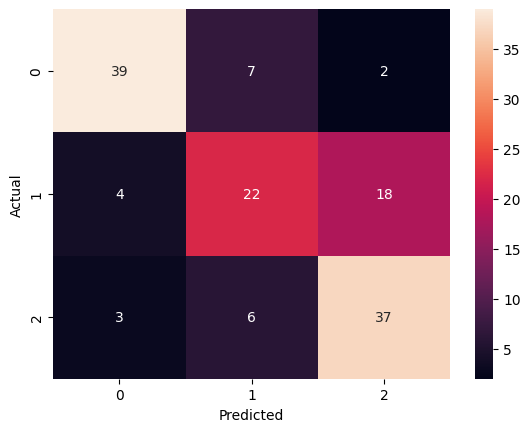

DecisionTree
Accuracy:  0.6739130434782609
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        48
           1       0.52      0.52      0.52        44
           2       0.73      0.87      0.79        46

    accuracy                           0.67       138
   macro avg       0.67      0.67      0.67       138
weighted avg       0.68      0.67      0.67       138

[[30 16  2]
 [ 8 23 13]
 [ 1  5 40]]


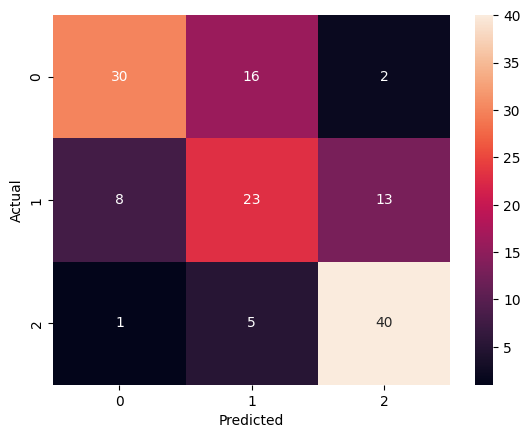

GaussianNB
Accuracy:  0.5289855072463768
              precision    recall  f1-score   support

           0       0.77      0.35      0.49        48
           1       0.34      0.36      0.35        44
           2       0.58      0.87      0.70        46

    accuracy                           0.53       138
   macro avg       0.56      0.53      0.51       138
weighted avg       0.57      0.53      0.51       138

[[17 25  6]
 [ 5 16 23]
 [ 0  6 40]]


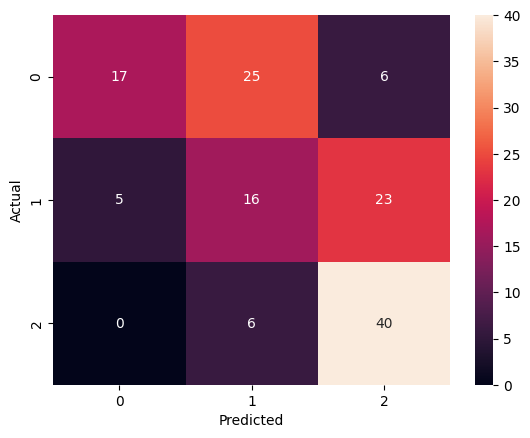

KNN
Accuracy: 0.6594202898550725
AUC (macro): 0.8613982271557451
MLP
Accuracy: 0.7101449275362319
AUC (macro): 0.8896348998685637
DecisionTree
Accuracy: 0.6739130434782609
AUC (macro): 0.8368234947715502
GaussianNB
Accuracy: 0.5289855072463768
AUC (macro): 0.7484285342712859
KNN
MLP
DecisionTree
GaussianNB


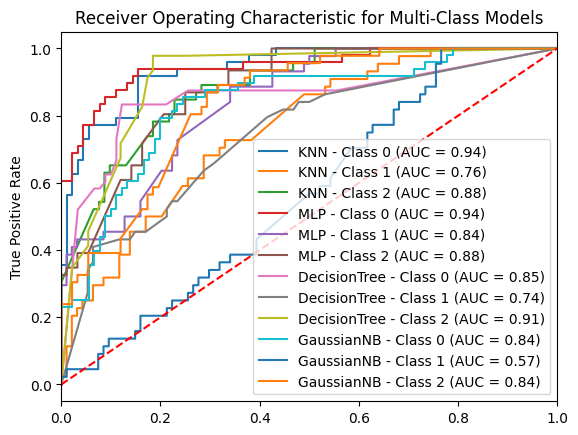

In [19]:
#  print the accuracy, classification report and confusion matrix for each model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve

accuracy = []
for i in range(len(models)):
    try:
        print(models[i][0])
        accuracy.append(accuracy_score(y_val, y_pred[i]))
        print('Accuracy: ', accuracy[i])
        print(classification_report(y_val, y_pred[i]))
        print(confusion_matrix(y_val, y_pred[i]))
        sns.heatmap(confusion_matrix(y_val, y_pred[i]), annot=True, fmt='d',)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    except Exception as e:
        print("Error:", e)

#auc score
from sklearn.metrics import roc_auc_score
for i in range(len(models)):
    try:
        print(models[i][0])  # Print the model name
        print('Accuracy:', accuracy[i])

        # Compute AUC for multi-class classification using one-vs-rest (OvR)
        auc = roc_auc_score(y_val, y_pred_proba[i], multi_class='ovr', average='macro')
        print('AUC (macro):', auc)
    except Exception as e:
        print(f"Error calculating AUC for model {i}: {e}")

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for multi-class ROC/AUC
n_classes = len(set(y_val))  # Determine the number of classes in y_val
y_val_bin = label_binarize(y_val, classes=[i for i in range(n_classes)])  # Binarize y_val for multi-class

fpr = {}
tpr = {}
roc_auc = {}

# Plot ROC curve for each model and each class (one-vs-rest)
for i in range(len(models)):
    print(models[i][0])  # Print the model name
    fpr[models[i][0]] = {}
    tpr[models[i][0]] = {}
    roc_auc[models[i][0]] = {}

    for class_label in range(n_classes):  # Loop through each class
        try:
            # Calculate the ROC curve for the current class
            fpr[models[i][0]][class_label], tpr[models[i][0]][class_label], _ = roc_curve(
                y_val_bin[:, class_label], y_pred_proba[i][:, class_label]
            )
            roc_auc[models[i][0]][class_label] = auc(fpr[models[i][0]][class_label], tpr[models[i][0]][class_label])

            # Plot the ROC curve for the current class
            plt.plot(fpr[models[i][0]][class_label], tpr[models[i][0]][class_label],
                     label=f'{models[i][0]} - Class {class_label} (AUC = {roc_auc[models[i][0]][class_label]:0.2f})')
        except Exception as e:
            print(f"Error calculating ROC curve for class {class_label} in model {i}: {e}")

# Plot the diagonal line (reference line for random predictions)
plt.plot([0, 1], [0, 1], 'r--')

# Set the plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Models')
plt.legend(loc="lower right")
plt.show()


In [20]:
# use trained model on TEST data
y_pred2 = []                 #for confusion matrix
y_pred_proba2 = []           #for ROC curve
for name, model in models:
    startPredicting2 = time.time()   # start predicting time
    y_pred2.append(model.predict(X_test))
    y_pred_proba2.append(model.predict_proba(X_test))
    endPredicting2 = time.time()     # end predicting time
    print(name, 'predicted,', 'Time taken:', \
          time.strftime("%H:%M:%S  ", time.gmtime(endPredicting2 - startPredicting2)))
    #reset time
    startPredicting2 = endPredicting2 = 0

KNN predicted, Time taken: 00:00:00  
MLP predicted, Time taken: 00:00:00  
DecisionTree predicted, Time taken: 00:00:00  
GaussianNB predicted, Time taken: 00:00:00  


KNN
Accuracy:  0.7007299270072993
              precision    recall  f1-score   support

           0       0.70      0.86      0.77        43
           1       0.53      0.42      0.47        40
           2       0.81      0.78      0.79        54

    accuracy                           0.70       137
   macro avg       0.68      0.69      0.68       137
weighted avg       0.69      0.70      0.69       137

[[37  6  0]
 [13 17 10]
 [ 3  9 42]]


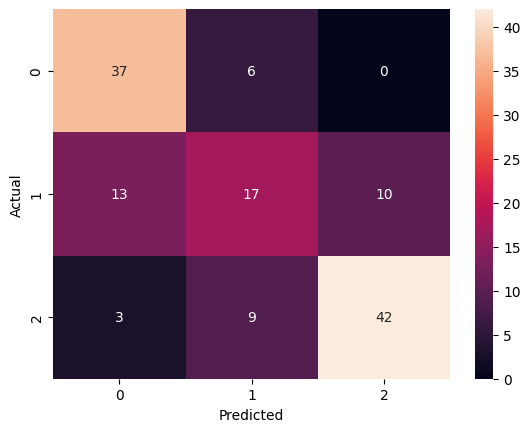

MLP
Accuracy:  0.6788321167883211
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        43
           1       0.48      0.40      0.44        40
           2       0.68      0.78      0.72        54

    accuracy                           0.68       137
   macro avg       0.67      0.66      0.66       137
weighted avg       0.67      0.68      0.67       137

[[35  6  2]
 [ 6 16 18]
 [ 1 11 42]]


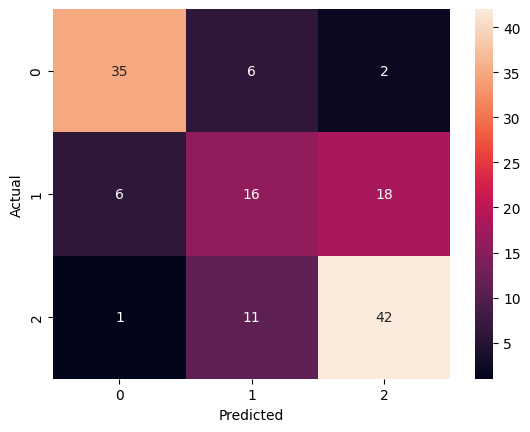

DecisionTree
Accuracy:  0.7372262773722628
              precision    recall  f1-score   support

           0       0.76      0.79      0.77        43
           1       0.56      0.55      0.56        40
           2       0.85      0.83      0.84        54

    accuracy                           0.74       137
   macro avg       0.72      0.72      0.72       137
weighted avg       0.74      0.74      0.74       137

[[34  8  1]
 [11 22  7]
 [ 0  9 45]]


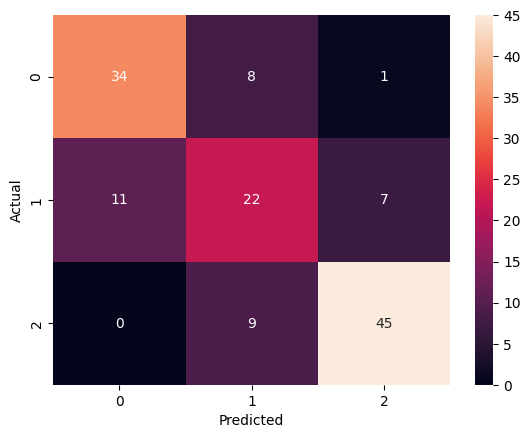

GaussianNB
Accuracy:  0.5985401459854015
              precision    recall  f1-score   support

           0       0.84      0.49      0.62        43
           1       0.41      0.42      0.42        40
           2       0.62      0.81      0.70        54

    accuracy                           0.60       137
   macro avg       0.62      0.58      0.58       137
weighted avg       0.63      0.60      0.59       137

[[21 14  8]
 [ 4 17 19]
 [ 0 10 44]]


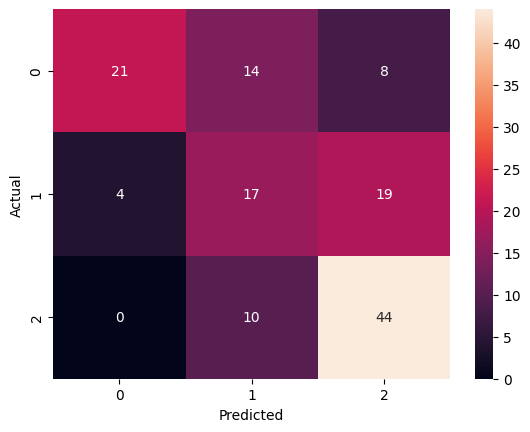

KNN
Accuracy: 0.7007299270072993
AUC (macro): 0.8694502249926258
MLP
Accuracy: 0.6788321167883211
AUC (macro): 0.8735536935972643
DecisionTree
Accuracy: 0.7372262773722628
AUC (macro): 0.8449647696178461
GaussianNB
Accuracy: 0.5985401459854015
AUC (macro): 0.7920604967654966
KNN
MLP
DecisionTree
GaussianNB


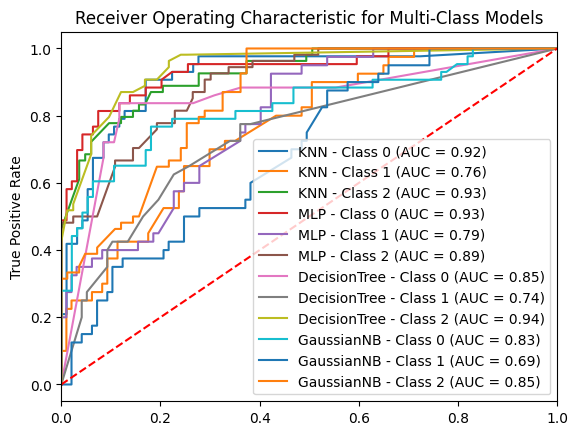

In [21]:
#  print the accuracy, classification report and confusion matrix for each model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve

accuracy = []
for i in range(len(models)):
    try:
        print(models[i][0])
        accuracy.append(accuracy_score(y_test, y_pred2[i]))
        print('Accuracy: ', accuracy[i])
        print(classification_report(y_test, y_pred2[i]))
        print(confusion_matrix(y_test, y_pred2[i]))
        sns.heatmap(confusion_matrix(y_test, y_pred2[i]), annot=True, fmt='d',)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    except Exception as e:
        print("Error:", e)

#auc score
from sklearn.metrics import roc_auc_score
for i in range(len(models)):
    try:
        print(models[i][0])  # Print the model name
        print('Accuracy:', accuracy[i])

        # Compute AUC for multi-class classification using one-vs-rest (OvR)
        auc = roc_auc_score(y_test, y_pred_proba2[i], multi_class='ovr', average='macro')
        print('AUC (macro):', auc)
    except Exception as e:
        print(f"Error calculating AUC for model {i}: {e}")

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for multi-class ROC/AUC
n_classes = len(set(y_test))  # Determine the number of classes in y_test
y_test_bin = label_binarize(y_test, classes=[i for i in range(n_classes)])  # Binarize y_test for multi-class

fpr = {}
tpr = {}
roc_auc = {}

# Plot ROC curve for each model and each class (one-vs-rest)
for i in range(len(models)):
    print(models[i][0])  # Print the model name
    fpr[models[i][0]] = {}
    tpr[models[i][0]] = {}
    roc_auc[models[i][0]] = {}

    for class_label in range(n_classes):  # Loop through each class
        try:
            # Calculate the ROC curve for the current class
            fpr[models[i][0]][class_label], tpr[models[i][0]][class_label], _ = roc_curve(
                y_test_bin[:, class_label], y_pred_proba2[i][:, class_label]
            )
            roc_auc[models[i][0]][class_label] = auc(fpr[models[i][0]][class_label], tpr[models[i][0]][class_label])

            # Plot the ROC curve for the current class
            plt.plot(fpr[models[i][0]][class_label], tpr[models[i][0]][class_label],
                     label=f'{models[i][0]} - Class {class_label} (AUC = {roc_auc[models[i][0]][class_label]:0.2f})')
        except Exception as e:
            print(f"Error calculating ROC curve for class {class_label} in model {i}: {e}")

# Plot the diagonal line (reference line for random predictions)
plt.plot([0, 1], [0, 1], 'r--')

# Set the plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Models')
plt.legend(loc="lower right")
plt.show()
